# Defensive Player Ranking and Insights

Now we are ready to generat defensive player ranking. Defensive player ranking is simply a weighted average of a players defensive plays multiplied by their importance (dot product). The ditribution of defensive plays per player shows us how often each player makes each defensive play. And if defensive plays that a player makes often are important from a defensive poitn of view then their ranking would be better. Below is how it is generated step by step

First we load the defensive plays importance and player defensive plays distribution

In [13]:
install.packages("janitor")

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [15]:
pacman::p_load(dplyr,readr, FactoInvestigate, Factoshiny, DT, corrplot, rio, FactoMineR, tidyr, shiny, lubridate, broom)
 
library(ggfortify)
library(ggplot2)
library(grid)
library(jpeg)
library(factoextra)
library(dplyr)
library(gtools)
library(janitor)
library(car)
options(warn=-1)


# Restore the object
player_def_plays=readRDS(file = "my_data_with_player_features_18.rds")
player_def_plays=as.data.frame(player_def_plays)
def_plays_imp=readRDS(file = "def_plays_imp.rds")

Transpose list of defensive plays importance and set the plays names as column names

In [16]:
def_plays_imp=as.data.frame(t(def_plays_imp))


names(def_plays_imp) <- def_plays_imp[2,]
def_plays_imp=def_plays_imp[1,]

Filter players with more than 700 plays then normalize their def plays count by dividing them by their total sum of plays

In [17]:
player_def_plays=player_def_plays[player_def_plays$sum>700,]
player_def_plays[,2:271]=player_def_plays[,2:271]/player_def_plays$sum
player_def_plays=subset(player_def_plays,select=-c(sum))


Order columns for list of def plays importance and player def plays distribution

In [18]:
player_def_plays=player_def_plays[,order(colnames(player_def_plays))] 
def_plays_imp=def_plays_imp[,order(colnames(def_plays_imp))]

Do the doct product between the two datasets and create the score. The score can be normalized further by having the best defender have a score of 100

In [19]:
def_plays_imp[] <- lapply(def_plays_imp, as.numeric)
product=as.data.frame(mapply(`*`,subset(player_def_plays,select=-defender_id),def_plays_imp))
product$score=rowSums(product,na.rm=TRUE)


product=cbind(product,player_def_plays$defender_id)

player_score=subset(product,select=c("score","player_def_plays$defender_id"))

colnames(player_score)=c("score","player_id")

In [20]:
player_score$score=100*(max(player_score$score)-player_score$score)/(max(player_score$score)-min(player_score$score))

Load The touch dataset to add player position and player height to the score data set to generate insights

In [21]:
# Restore the object
touch_data=readRDS(file = "my_data_with_18_clusters.rds")

touch_data$def_pos[touch_data$def_pos=='PG-SG']='PG'
touch_data$def_pos[touch_data$def_pos=='SF-SG']='SF'
touch_data$def_pos[touch_data$def_pos=='SG-PG']='SG'
touch_data$def_pos[touch_data$def_pos=='PF-SF']='PF'
touch_data$def_pos[touch_data$def_pos=='SF-PF']='SF'
touch_data$def_pos[touch_data$def_pos=='SG-SF']='SG'
touch_data$def_pos[touch_data$def_pos=='G-F']='PG'
touch_data$def_pos[touch_data$def_pos=='F']='PF'


Combine and merge the two datasets based on player_id

In [22]:

player_height=touch_data %>% group_by(defender_id) %>% summarise(max_height=min(def_height))
colnames(player_height)=c("player_id","height")

player_pos=unique(touch_data[,c('defender_id','def_pos')])
colnames(player_pos)=c("player_id","def_pos")
player_score=merge(player_score,player_height,by="player_id")
player_score=merge(player_score,player_pos,by="player_id")

Now we have player height and position merged with defensive player score. We can run a simple linear regression to look at the effect of each parameter on defensove score

In [23]:
model=lm(score~height+def_pos,data=player_score)
summary(model)


Call:
lm(formula = score ~ height + def_pos, data = player_score)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.148  -6.631   0.266   7.104  26.287 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.9448    25.1482   0.515  0.60695    
height        0.7321     0.3019   2.425  0.01563 *  
def_posPF    -4.0643     1.5450  -2.631  0.00877 ** 
def_posPG   -37.5915     3.0404 -12.364  < 2e-16 ***
def_posSF   -29.6566     1.8450 -16.074  < 2e-16 ***
def_posSG   -38.9691     2.3326 -16.706  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.5 on 524 degrees of freedom
Multiple R-squared:  0.7622,	Adjusted R-squared:  0.7599 
F-statistic: 335.8 on 5 and 524 DF,  p-value: < 2.2e-16


Insights from the above linear regression:

- Height and player position are good predictors of defensive ranking --> Adjusted R squared is around 76% with both height and position as significant variables with p-values below 5 percent
- For one inch increase in height there is an average three quarter increase in defensive score
- Centers have the best defensive scores followed by Power Forwards, Small Forwards, Point Guards and finally Shooting Guards




A quick scatter plot shows the strong relationship between height and defensive score. we have a correlation of 74% between the two variables even without any transformation

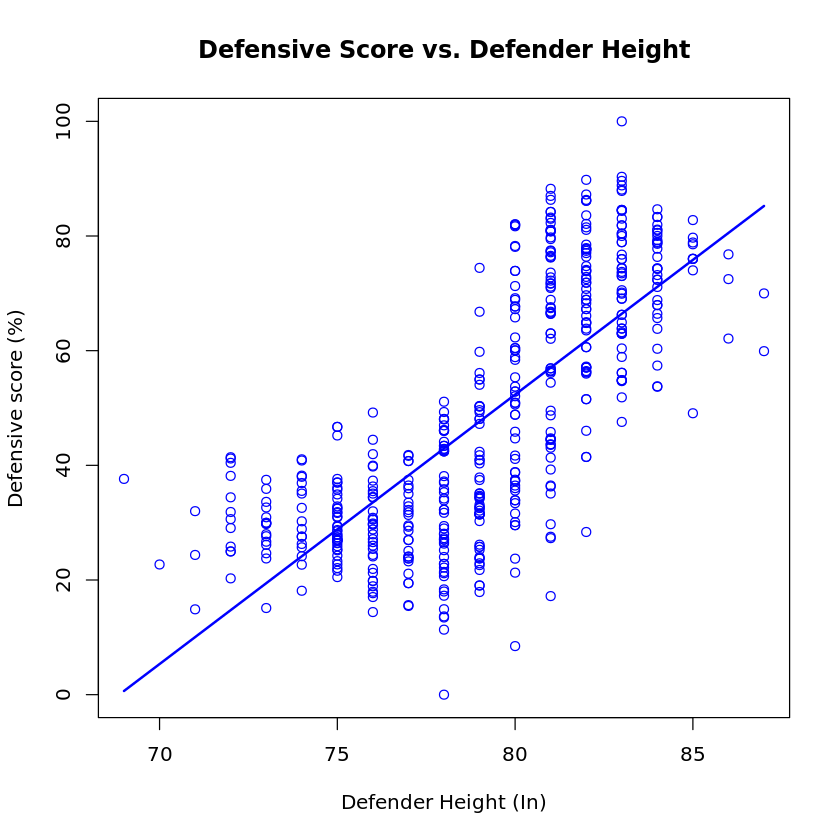

In [63]:
library(car)

yhat <-  model$fitted

scatterplot(player_score$score ~ player_score$height, boxplots=FALSE, xlab="Defender Height (In)", ylab="Defensive score (%)",smooth=FALSE,main="Defensive Score vs. Defender Height",grid=FALSE)

How does height affect defensive ability within each player position? Is height also a factor that affects defensive score within each player group? for that we can run a fixed effects regression

In [57]:
model_fixed=lm(score~height+factor(def_pos)-1,data=player_score)
          
summary(model_fixed)


Call:
lm(formula = score ~ height + factor(def_pos) - 1, data = player_score)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.148  -6.631   0.266   7.104  26.287 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
height              0.7321     0.3019   2.425   0.0156 *
factor(def_pos)C   12.9448    25.1482   0.515   0.6070  
factor(def_pos)PF   8.8805    24.6395   0.360   0.7187  
factor(def_pos)PG -24.6467    22.5140  -1.095   0.2741  
factor(def_pos)SF -16.7118    24.0865  -0.694   0.4881  
factor(def_pos)SG -26.0244    23.3257  -1.116   0.2651  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.5 on 524 degrees of freedom
Multiple R-squared:  0.9613,	Adjusted R-squared:  0.9608 
F-statistic:  2167 on 6 and 524 DF,  p-value: < 2.2e-16


Height is significant within player position groups as well. Below we plot the effect of height within each group. We can see how each player group ranks in terms of their defensive score

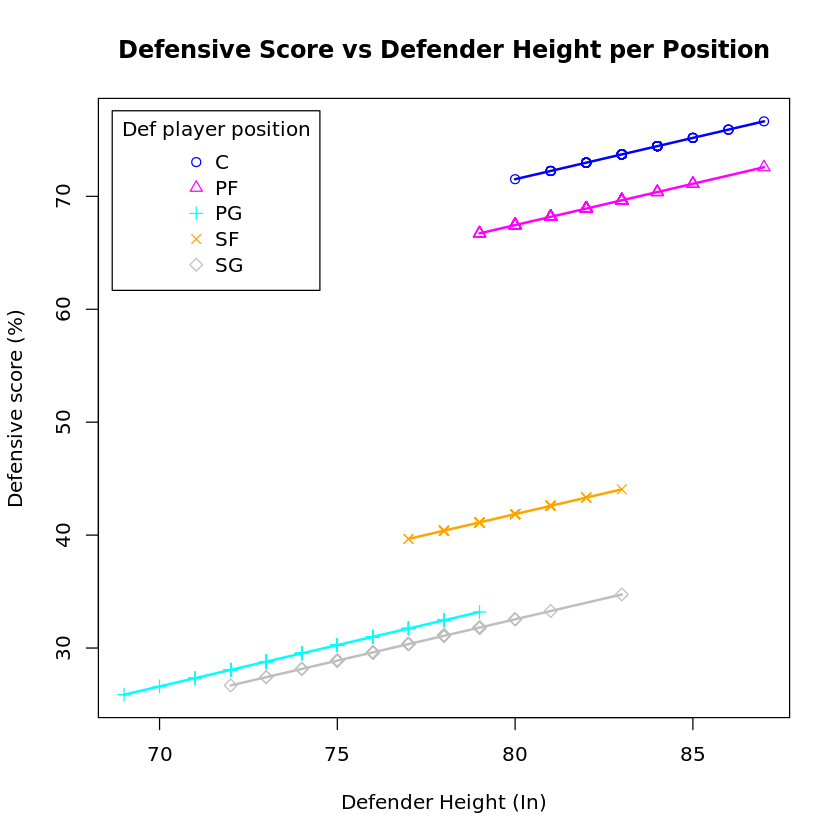

In [68]:

yhat <-  model_fixed$fitted 

scatterplot(yhat~player_score$height|player_score$def_pos, boxplots=FALSE, xlab="Defender Height (In)",
            ylab="Defensive score (%)",smooth=FALSE,
            grid=FALSE,legend=list(title="Def player position",coords="topleft"),main="Defensive Score vs Defender Height per Position")